# GAN

In this section you are required to implement vanilla GAN. The general structure for GAN is given below. You can use it as a template.

Generative Adversarial Networks are used for learning distribution of data by playing a game between two networks which are generator and discriminator.

There are couple of studies you can examine before implementing the model.

Generative Adversarial Networks: https://arxiv.org/abs/1406.2661

Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks: https://arxiv.org/abs/1511.06434

**Link of the latest trained model= https://drive.google.com/open?id=1gaDp0qYBfa-A2g6jPB0jrqDkGHTKGxhY **

# Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

Turkish:
https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d



In [1]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Thu Dec 12 02:56:25 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:01:00.0  On |                  N/A |
| 36%   67C    P8    18W / 250W |     96MiB / 12209MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# Load the Logo data as instructed below

In [3]:
class logoLoader(Dataset):
    def __init__(self, path, transform=None):
      d_array = []
      self.transform = transform
      for i in range(5):
        root = os.path.join(path, 'LLD-icon_data_{}.pkl'.format(i))
        data = np.load(root, encoding='latin1',allow_pickle=True)
        d_array.append(data)
      
      self.data = np.concatenate((d_array[0],d_array[1],d_array[2],d_array[3],d_array[4]))
      print(self.data.shape)      
      
    # This method should be overrided in order to access the inside of dataset
    def __getitem__(self, ix):
        data_item = self.data[ix]
        # Load image
        data = Image.fromarray(data_item)
        if self.transform:
            data = self.transform(data)
        return data
      
    # This method should be overrided in order to make it work along with DataLoader class
    def __len__(self):
        return len(self.data)

In [4]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = logoLoader(path='icondataset',transform=transform)
data_loader = DataLoader(dataset=dataset, batch_size=128 , num_workers=8, shuffle=True)

(486377, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


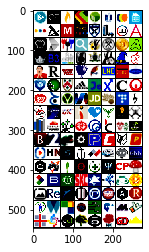

In [5]:
import torchvision
# Lets see some examples
loader=iter(data_loader)
img=next(loader)
grid = torchvision.utils.make_grid(img)
npimg = grid.numpy()
plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
plt.show()

# Implement the Discriminator Architecture of your Design

Use Conv2d, Linear and Activation Layers to design a Discriminator

Please note: Pay attention to whether Sigmoid Unit at the last layer is added in the Architecture OR in the Loss function, because in implementations of some loss functions in Pytorch, sigmoid unit is included by default. In this notebook we use BCELoss (given default) so you should add sigmoid to last layer.

In [6]:
latent_space_dim = 512
discriminator_filter_size = 64
generator_filter_size = 64

# My GAN network is similar to the DCGAN one of the earliest convolutional GAN architectures
# But in my GAN network latent space dimension is bigger than the DCGAN which empowers the model
# by containing more information as a latent space.
# Training process of the discriminator and generator considers the points that DCGAN authors defined.

# DC Gan proposes weight initialization from 0.02 Gaussian distribution
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [7]:
class Discriminator(torch.nn.Module):
    """
    Implement discriminator network
    """
    def __init__(self):
        """
        Implement architecture
        """
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, discriminator_filter_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discriminator_filter_size, discriminator_filter_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_filter_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discriminator_filter_size * 2, discriminator_filter_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_filter_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discriminator_filter_size * 4, discriminator_filter_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_filter_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(discriminator_filter_size * 8, 1, 2, 1, 0, bias=False),
            nn.Sigmoid()
        )        
        
    def forward(self, x):
        """
        Implement forward-pass
        """
        x = self.main(x)
        
        return x

In [8]:
discriminator = Discriminator()
# As DC GAN paper propose we initialize weights from small gaussian distribution
discriminator.apply(weights_init)
discriminator = discriminator.cuda()

# Implement the Generator Architecture of your Design

You can use (Upsample, Conv2d) pair or ConvTranspose2d and Activation Layers to design a Generator. Add Tanh to last layer for better training.


In [9]:
class Generator(torch.nn.Module):
    """
    Implement Generator Network
    """
    def __init__(self):
        """
        Implement architecture
        """
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( latent_space_dim, generator_filter_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(generator_filter_size * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(generator_filter_size * 8, generator_filter_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_filter_size * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(generator_filter_size * 4, generator_filter_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_filter_size * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(generator_filter_size * 2, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
        
    def forward(self, x):
        """
        Implement forward-pass
        """
        x = self.main(x)
        return x

In [10]:
generator = Generator()
generator.apply(weights_init)
generator = generator.cuda()

# Initialization of the Optimizer: You can change the Parameters according to your needs

In [11]:
disc_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3, betas = [0.5,0.999])
gen_optimizer = optim.Adam(generator.parameters(), lr=1e-3, betas = [0.5,0.999])

# VanillaGAN uses Binary Cross Entropy loss, instatiated below.

In [12]:
loss = nn.BCELoss()
fixed_noise = torch.randn(128, latent_space_dim, 1, 1).cuda()
real_label = 1
fake_label = 0


# Implement training loop

In [13]:
num_epochs = 6
losses_iter_discriminator = []
losses_epoch_discriminator = []
losses_iter_generator = []
losses_epoch_generator = []
generator.train()
discriminator.train()
for epoch in range(num_epochs):
    count = 0
    for n_batch, (real_batch) in enumerate(data_loader):
        
        disc_optimizer.zero_grad()
        real_batch = real_batch.cuda()
        batch_size = real_batch.size(0)
        label = torch.full((batch_size,1,1,1), real_label).cuda()
        output = discriminator(real_batch)
        disc_real_error = loss(output, label)
        disc_real_error.backward()

        # train with fake
        noise = torch.randn(batch_size, latent_space_dim, 1, 1).cuda()
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach())
        disc_real_fake = loss(output, label)
        disc_real_fake.backward()
        d_error = disc_real_error + disc_real_fake
        losses_iter_discriminator.append(d_error.item())
        disc_optimizer.step()

        # Update the Generator
        
        generator.zero_grad()
        # Fake labels are real for generator
        label.fill_(real_label)  
        # Discriminate the  fake images
        output = discriminator(fake)
        g_error = loss(output, label)
        losses_iter_generator.append(g_error.item())
        #Update adversarial loss
        g_error.backward()
        
        gen_optimizer.step()
        # Call Discriminator Training function with appropriate parameters
        
        # Call Generator Training function with appropriate parameters
        
        if (n_batch + 1) % 100 == 0:
            print("epoch: {%d}, batch number: {%d}, d_error: {%.4f}, g_error: {%.4f}" % 
                  (epoch + 1, n_batch + 1, d_error.item(), g_error.item()))
            
    losses_epoch_discriminator.append(np.mean(losses_iter_discriminator[-count:]))
    losses_epoch_generator.append(np.mean(losses_iter_generator[-count:]))

epoch: {1}, batch number: {100}, d_error: {0.4595}, g_error: {2.5619}
epoch: {1}, batch number: {200}, d_error: {0.5987}, g_error: {2.7224}
epoch: {1}, batch number: {300}, d_error: {0.9717}, g_error: {5.3952}
epoch: {1}, batch number: {400}, d_error: {1.1355}, g_error: {2.8350}
epoch: {1}, batch number: {500}, d_error: {0.8403}, g_error: {3.3518}
epoch: {1}, batch number: {600}, d_error: {0.8378}, g_error: {3.8152}
epoch: {1}, batch number: {700}, d_error: {0.4442}, g_error: {2.7850}
epoch: {1}, batch number: {800}, d_error: {1.2491}, g_error: {5.0412}
epoch: {1}, batch number: {900}, d_error: {1.4146}, g_error: {5.8818}
epoch: {1}, batch number: {1000}, d_error: {1.3219}, g_error: {1.4648}
epoch: {1}, batch number: {1100}, d_error: {0.6077}, g_error: {2.7931}
epoch: {1}, batch number: {1200}, d_error: {0.7308}, g_error: {2.4835}
epoch: {1}, batch number: {1300}, d_error: {1.3523}, g_error: {3.0820}
epoch: {1}, batch number: {1400}, d_error: {0.8328}, g_error: {4.1202}
epoch: {1}, bat

epoch: {4}, batch number: {300}, d_error: {0.0513}, g_error: {4.9595}
epoch: {4}, batch number: {400}, d_error: {0.0360}, g_error: {5.3357}
epoch: {4}, batch number: {500}, d_error: {0.0111}, g_error: {5.2332}
epoch: {4}, batch number: {600}, d_error: {1.9961}, g_error: {0.9734}
epoch: {4}, batch number: {700}, d_error: {0.0762}, g_error: {4.1856}
epoch: {4}, batch number: {800}, d_error: {1.1803}, g_error: {1.1383}
epoch: {4}, batch number: {900}, d_error: {0.0259}, g_error: {5.6196}
epoch: {4}, batch number: {1000}, d_error: {0.0276}, g_error: {4.9467}
epoch: {4}, batch number: {1100}, d_error: {0.0074}, g_error: {7.0914}
epoch: {4}, batch number: {1200}, d_error: {0.0121}, g_error: {5.9413}
epoch: {4}, batch number: {1300}, d_error: {0.0107}, g_error: {5.5409}
epoch: {4}, batch number: {1400}, d_error: {0.0806}, g_error: {3.5303}
epoch: {4}, batch number: {1500}, d_error: {0.3290}, g_error: {2.0379}
epoch: {4}, batch number: {1600}, d_error: {0.0140}, g_error: {6.6766}
epoch: {4}, b

## Report the training loss curves and test results (generated images) vanillaGAN. Also briefly discuss the results.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

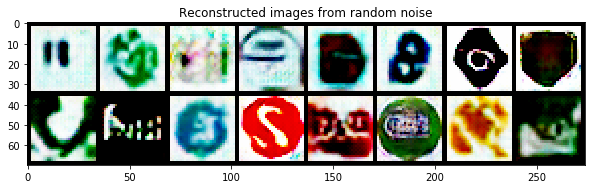

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

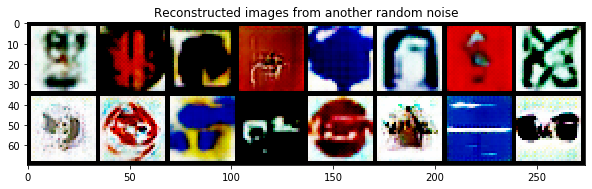

In [29]:
import torchvision.utils as vutils
generator.eval()
noise = torch.randn(batch_size, latent_space_dim, 1, 1).cuda()


fake = generator(noise)
from IPython.display import Image
from IPython.core.display import Image, display

plt.figure()
fake = fake.cpu().detach()
plt.figure(figsize=(10,10))
batch_output_grid = torchvision.utils.make_grid(fake[:16]).numpy()
plt.imshow(np.transpose(batch_output_grid, (1, 2, 0)))
plt.title('Reconstructed images from random noise')
plt.show()

noise = torch.randn(batch_size, latent_space_dim, 1, 1).cuda()
fake = generator(noise)
plt.figure()
fake = fake.cpu().detach()
plt.figure(figsize=(10,10))
batch_output_grid = torchvision.utils.make_grid(fake[:16]).numpy()
plt.imshow(np.transpose(batch_output_grid, (1, 2, 0)))
plt.title('Reconstructed images from another random noise')
plt.show()

**As you can see there are some good images that can be a logo for example dog in front of circle. Also model generates lots of vivid colors. But in overall the structures are not meaningfull and therefore it may be best to increase the impact of the BCE loss rather than adversarial loss. However In general within a short time it generates a few good logos.**

**Loss curves don't say much about the training process but it is easy to see that as discriminator loss increase the generator loss first increase then decrease.**

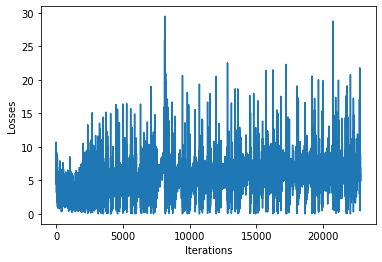

In [30]:
# Plot Generator Loss
plt.figure()
plt.plot([i+1 for i in range(len(losses_iter_generator))],losses_iter_generator)
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.show()

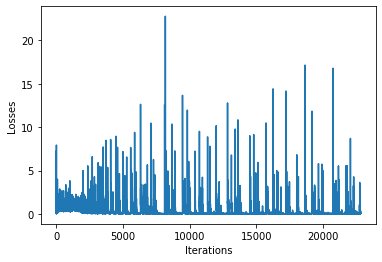

In [31]:
# Plot Discriminator Loss
plt.figure()
plt.plot([i+1 for i in range(len(losses_iter_discriminator))],losses_iter_discriminator)
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.show()

#### After you have completed the training, save your generator model using the following command
**Link of the latest trained model= https://drive.google.com/open?id=1gaDp0qYBfa-A2g6jPB0jrqDkGHTKGxhY **

In [32]:
student_id = 504191504
torch.save(generator.state_dict(),'drive/My Drive/blg561/{}_GAN.pth'.format(student_id))